# Varying R and U for an Oil Droplet
---

In this program, we find the contact time, coefficient of restitution and maximal deformation of an oil droplet impacting a solid surface. We vary the initial radius of the droplet as well as its initial velocity, and assume spheroidal deformation.

In [1]:
#Import necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
#Define a function that finds the peaks of v and thus approximates the coefficient of restitution.
from scipy.signal import find_peaks

#Function that computes the restitution coefficient for the first bounce.
def restitution(v):
    return abs(max(v)/min(v))

#Function that computes the contact time for each bounce.
def contact_time(x,r,t):
    #Find the location of the peaks to split up x into time intervals with only one bounce.
    peaks,_ = find_peaks(x, height=1.05)
    peaks = np.insert(peaks, 0, 0)
    
    #Determine the contact time for each bounce.
    tstep = t[1]-t[0]
    if len(peaks)<=1:
        x1 = x.copy()
        r1 = r.copy()
        x1[x1-r1>0] = 1000
        x1 = np.delete(x1, np.where(x1==1000))
        tc = np.array([(len(x1)-1)*tstep])
    else:
        tc = np.zeros(len(peaks)-1)
        for i in range(len(peaks)-1):
            x1 = x[peaks[i]:peaks[i+1]].copy()
            r1 = r[peaks[i]:peaks[i+1]].copy()
            x1[x1-r1>0] = 1000
            x1 = np.delete(x1, np.where(x1==1000))
            tc[i] = (len(x1)-1)*tstep
    return tc

In [3]:
#Define the nondimensional ODE system.
def zrODE(y,t, Bod,Ohd,Wed,Ca,Nw):
    #Split into the different components
    z, v, r, u = y
    
    #Define the contact force, which is 0 when the expression is negative
    f = (1/2)*(1 + (1/Bod)*(Ca*v - 3.8*Ohd*v - Nw*(z-1)))
    
    #Define the ODEs. At this point, the mathematical reasoning is somewhat out of the window, and I am just doing what works.
    zdot = v.copy()
    if z-r>0 or f<=0:        
        rdot = u.copy()
        vdot = -Ca*v - Bod
        udot = -3.8*Ohd*u - Nw*(r-1)
    else:
        rdot = zdot
        vdot = -Ca*v + Bod*(f-1)
        udot = -3.8*Ohd*u - Nw*(r-1) - Bod*f
    
    return zdot, vdot, rdot, udot

In [4]:
#Function that solves the system for a given set of parameters,
#then plots the coefficient of restitution and contact time for each bounce.
def runner(t, R,U):
    #Time scale.
    T   = np.sqrt((pd*(R**3))/st)
    
    #Prescribe the nondimensional parameters for alternative cases. In the ranges of Blanchette's Paper.
    Rea = U*R/va
    Bod = pd*g*R*R/st
    Ohd = vd*np.sqrt(pd/(st*R))
    Wed = pd*U*U*R/st
    Nw  = 5.84
    Ca  = ((9*pa*va*T)/(2*R*R*pd))*(1+(Rea/6))
    V   = -np.sqrt(Wed)
    
    #Define the initial condition.
    y0 = np.array([2,V,1,0])
    
    #Compute the solution approximation and split into the displacement and velocity.    
    y = odeint(zrODE, y0, t, args=(Bod,Ohd,Wed,Ca,Nw))
    
    z = y[:,0]
    v = y[:,1]
    r = y[:,2]
    u = y[:,3]
    
    #Make sure case is physical.
    if min(r)>0:
    
        #Compute the coefficient of restitution and contact time for the first bounce.
        tc_arr = contact_time(z,r,t)
        tc = tc_arr[0]
        CR = restitution(v)
    
        #Find the maximal horizontal radius, assuming spheroidal deformation.
        hr_max = 1/np.sqrt(min(r))
    
        return y, tc, CR, hr_max
    
    else:
        return np.nan, np.nan, np.nan, np.nan

In [5]:
#Function that does the whole thing for varying Bond number.
def varyR(R_arr,U):
    #Set up arrays for the contact time and coefficient of restitution and maximal horizontal radius.
    l = len(R_arr)
    tc_arr = np.zeros(l)
    CR_arr = np.zeros(l)
    hr_arr = np.zeros(l)
    
    #Safety line to make sure we have the correct U (had problems with this before).
    Ud = U
    
    #Compute the solution, for each Bo.
    for i in range(l):        
        Rd = R_arr[i]
        y_sol, tc, CR, hr = runner(t, Rd,Ud)
        
        #We need dimensional time here as nondimensional time units depends on R. The 1000 gives us times in ms.
        T = np.sqrt((pd*(Rd**3))/st)
        
        tc_arr[i] = 1000*T*tc
        CR_arr[i] = CR
        hr_arr[i] = hr
        
        
    #Determine the Weber Number in each case so we can plot it against the maximal deformation.
    We_arr = pd*(Ud**2)*(R_arr)/st
    
    #Plot the contact time.
    plt.subplot(221)
    plt.scatter(R_arr, tc_arr, marker='x', s=100, label="U="+str(Ud))
    
    #Plot the coefficient of restitution.
    plt.subplot(222)
    plt.scatter(R_arr, CR_arr, marker='x', s=100, label="U="+str(Ud))
    
    #Plot the maximal horizontal radius.
    plt.subplot(223)
    plt.scatter(R_arr, R_arr*hr_arr, marker='x', s=100, label="U="+str(Ud))
    
    #Plot the maximal horizontal radius against Weber number.
    plt.subplot(224)
    plt.scatter(We_arr, (hr_arr-np.ones(l)), marker='x', s=100, label="U="+str(Ud))

In [6]:
#Function that does the whole thing for varying Bond number.
def varyU(R,U_arr):
    #Set up arrays for the contact time and coefficient of restitution and maximal horizontal radius.
    l = len(U_arr)
    tc_arr = np.zeros(l)
    CR_arr = np.zeros(l)
    hr_arr = np.zeros(l)
    
    #Safety line to make sure we have the correct U (had problems with this before).
    Rd = R
    
    #Compute the solution, for each Bo.
    for i in range(l):        
        Ud = U_arr[i]
        y_sol, tc, CR, hr = runner(t, Rd,Ud)
        
        #We need dimensional time here as nondimensional time units depends on R. The 1000 gives us times in ms.
        T = np.sqrt((pd*(Rd**3))/st)
        
        tc_arr[i] = 1000*T*tc
        CR_arr[i] = CR
        hr_arr[i] = hr
   

    #Determine the Weber Number in each case so we can plot it against the maximal deformation.
    We_arr = pd*(U_arr**2)*Rd/st
    
    #Plot the contact time.
    plt.subplot(221)
    plt.scatter(U_arr, tc_arr, marker='x', s=100, label="R="+str(Rd))
    
    #Plot the coefficient of restitution.
    plt.subplot(222)
    plt.scatter(U_arr, CR_arr, marker='x', s=100, label="R="+str(Rd))
    
    #Plot the maximal horizontal radius.
    plt.subplot(223)
    plt.scatter(U_arr, Rd*hr_arr, marker='x', s=100, label="R="+str(Rd))
    
    #Plot the maximal horizontal extension against Weber number.
    plt.subplot(224)
    plt.scatter(We_arr, (hr_arr-np.ones(l)), marker='x', s=100, label="R="+str(Rd))

In [7]:
#Function that adds details to each plot.
def details(vary):
    #Add details to the first plot.
    plt.subplot(221)
    plt.xlabel(vary, fontsize=14)
    plt.xticks(fontsize=14)
    plt.xscale('log')
    plt.ylabel("Contact Time (ms)", fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Contact Time for Varying "+vary, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid()

    #Add details to the second plot.
    plt.subplot(222)
    plt.xlabel(vary, fontsize=14)
    plt.xticks(fontsize=14)
    plt.xscale('log')
    plt.ylabel("Coefficient of Restitution", fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Coefficient of Restitution for Varying "+vary, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid()
    
    #Add details to the third plot.
    plt.subplot(223)
    plt.xlabel(vary, fontsize=14)
    plt.xticks(fontsize=14)
    plt.xscale('log')
    plt.ylabel("Maximal Horizontal Radius (m)", fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale('log')
    plt.title("Maximal Horizontal Radius for Varying "+vary, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid()
    
    #Add details to the fourth plot.
    plt.subplot(224)
    plt.xlabel('Log of the Weber Number', fontsize=14)
    plt.xticks(fontsize=14)
    plt.xscale('log')
    plt.ylabel("Log of the Maximal (Nondimensional) Extension", fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale('log')
    plt.title("Maximal (Nondimensional) Extension for Varying "+vary, fontsize=20)
    plt.legend(fontsize=14)
    plt.grid()

In [8]:
#Define the dimensional parameters.
#Drop parameters.
R0   = 0.0005
pd  = 917.2
mud = 0.084
vd  = mud/pd
U0   = 0.25

#Air parameters.
pa  = 1.20
mua = 1.813*10**(-5)
va  = mua/pa

#Others.
st  = 0.0320
g   = 9.81

In [9]:
#Set up the time array.
tf = 30
t = np.linspace(0,tf,1000*tf+1)

In [10]:
#Set up the parameter ranges we want to look at R.
Rd_arr = np.array([0.0001,0.0003,0.0006,0.001,])
Ud0 = 0.5
Ud1 = 0.25
Ud2 = 0.1
Ud3 = 0.05
Ud4 = 0.01

C:\Users\willg\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


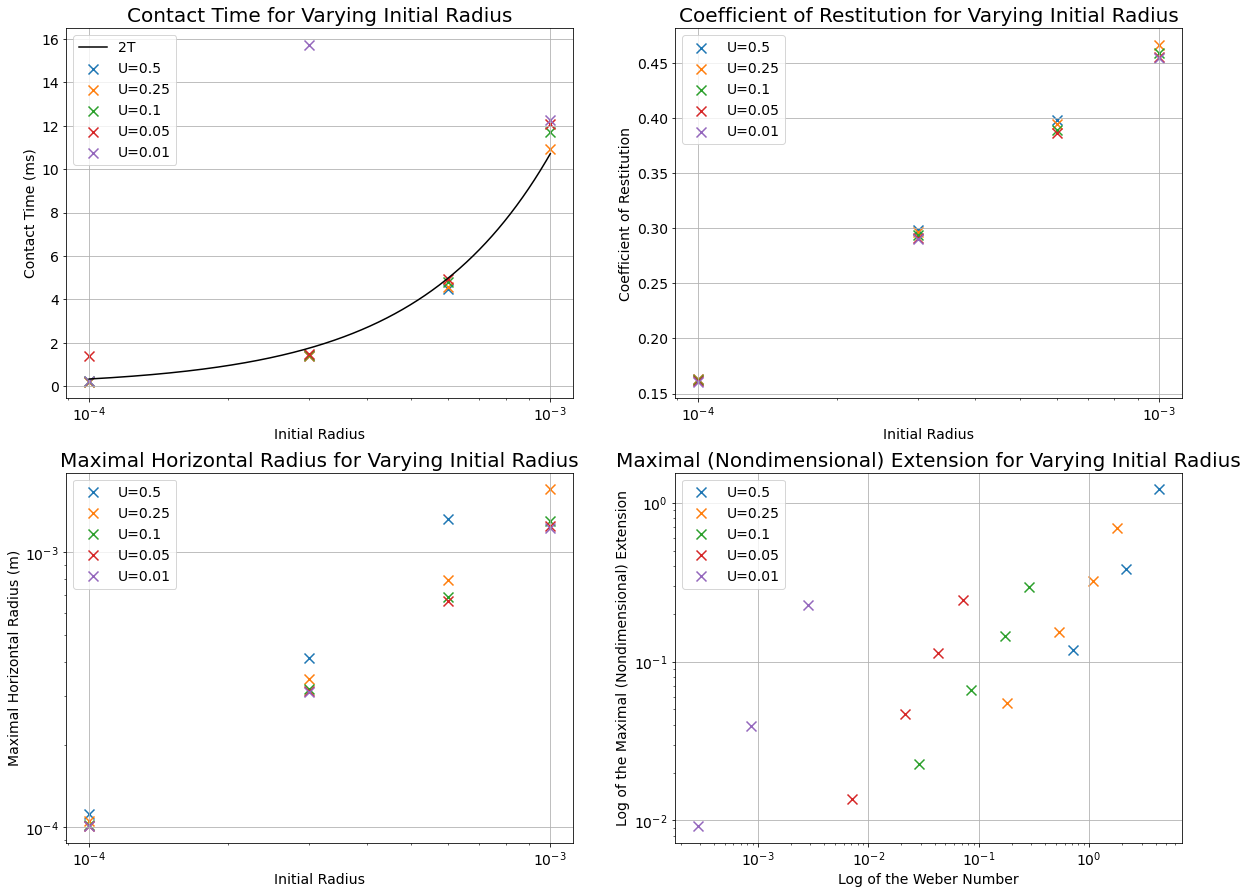

In [11]:
#Initialise the figure.
plt.figure(figsize=(20,15))

plt.subplot(221)
X = np.linspace(0.0001,0.001,1001)
Y = 2*1000*np.sqrt(pd*(X**3)/st)
plt.plot(X, Y, label='2T', color='black')

varyR(Rd_arr,Ud0)
varyR(Rd_arr,Ud1)
varyR(Rd_arr,Ud2)
varyR(Rd_arr,Ud3)
varyR(Rd_arr,Ud4)

details('Initial Radius')

plt.show()

In [12]:
#Set up the parameter ranges we want to look at for varying U.
Ud_arr = np.array([0.005,0.01,0.05,0.1,0.25,0.5,1])
Rd0 = 0.0001
Rd1 = 0.0005
Rd2 = 0.001
Rd3 = 0.05

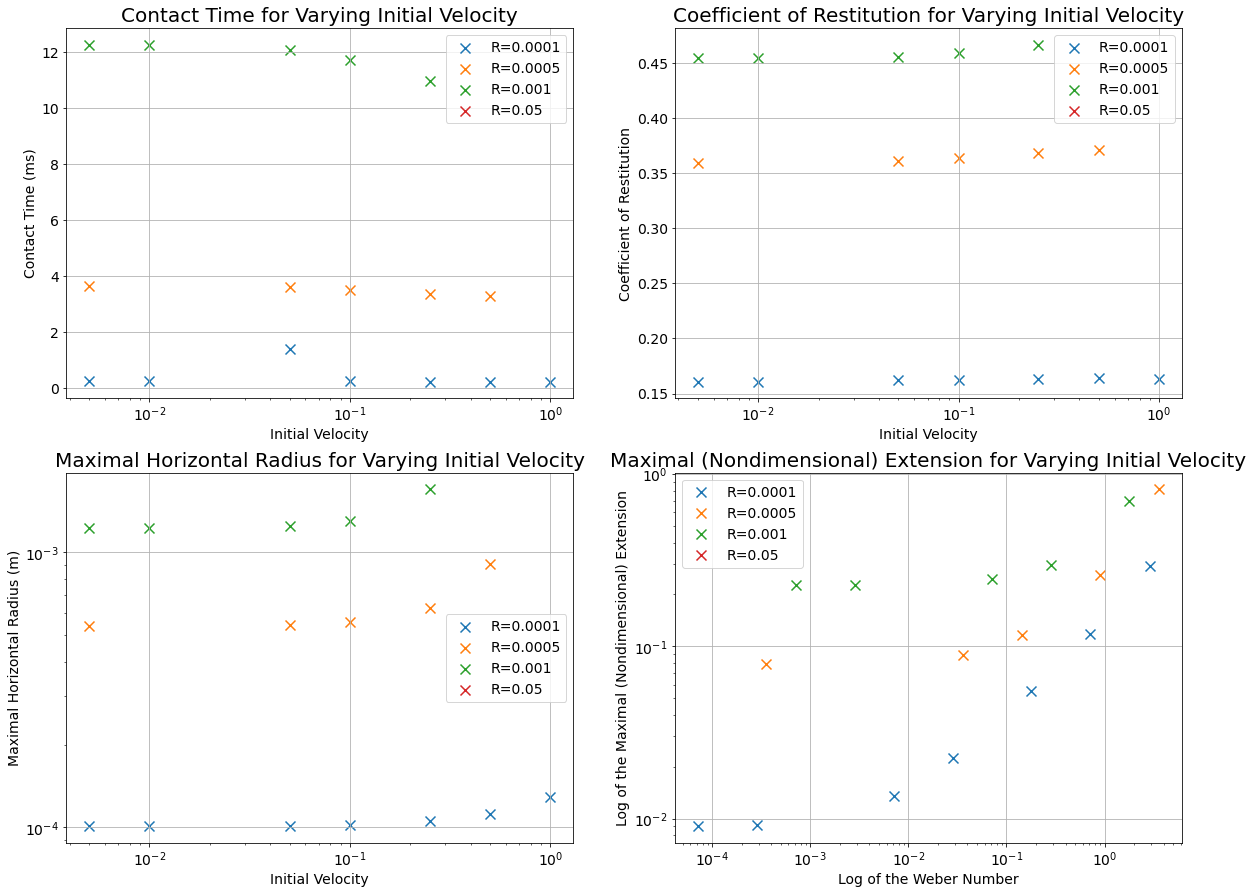

In [13]:
#Initialise the figure.
plt.figure(figsize=(20,15))

varyU(Rd0,Ud_arr)
varyU(Rd1,Ud_arr)
varyU(Rd2,Ud_arr)
varyU(Rd3,Ud_arr)

details('Initial Velocity')

plt.show()